In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, DefineVariable
import scipy.sparse as sp
import scipy.sparse.linalg as spln
import metropolishastings as mh
from state import State

We use the Metropolis-Hastings algorithm to perform Bayesian estimation of the unkown parameters of a logit model. 


# Definition of the choice model and the log likelihood

Load and clean the data

In [2]:
df = pd.read_csv('swissmetro.dat', sep='\t')
database = db.Database("swissmetro",df)
globals().update(database.variables)
exclude = (( PURPOSE != 1 ) * (  PURPOSE   !=  3  ) +  ( CHOICE == 0 )) > 0
database.remove(exclude)


Parameters to be estimated

In [3]:
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 0)
ASC_SM = Beta('ASC_SM', 0, None, None, 1)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

Definition of new variables

In [4]:
SM_COST = SM_CO * (GA == 0)
TRAIN_COST = TRAIN_CO * (GA == 0)

# Definition of new variables: adding columns to the database
CAR_AV_SP = DefineVariable('CAR_AV_SP', CAR_AV * (SP != 0), database)
TRAIN_AV_SP = DefineVariable('TRAIN_AV_SP', TRAIN_AV * (SP != 0), database)
TRAIN_TT_SCALED = DefineVariable('TRAIN_TT_SCALED', TRAIN_TT / 100.0, database)
TRAIN_COST_SCALED = DefineVariable(
    'TRAIN_COST_SCALED', TRAIN_COST / 100, database
)
SM_TT_SCALED = DefineVariable('SM_TT_SCALED', SM_TT / 100.0, database)
SM_COST_SCALED = DefineVariable('SM_COST_SCALED', SM_COST / 100, database)
CAR_TT_SCALED = DefineVariable('CAR_TT_SCALED', CAR_TT / 100, database)
CAR_CO_SCALED = DefineVariable('CAR_CO_SCALED', CAR_CO / 100, database)


Definition of the utility functions

In [5]:
V1 = ASC_TRAIN + B_TIME * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED
V2 = ASC_SM + B_TIME * SM_TT_SCALED + B_COST * SM_COST_SCALED
V3 = ASC_CAR + B_TIME * CAR_TT_SCALED + B_COST * CAR_CO_SCALED

Associate utility functions with the numbering of alternatives

In [6]:
V = {1: V1, 2: V2, 3: V3}

Associate the availability conditions with the alternatives

In [7]:
av = {1: TRAIN_AV_SP, 2: SM_AV, 3: CAR_AV_SP}

Definition of the model. This is the contribution of each
observation to the log likelihood function.

In [8]:
logprob = models.loglogit(V, av, CHOICE)

Create the Biogeme object

In [9]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = '01logit'
biogeme.generateHtml = False
biogeme.generatePickle = False

# Estimation with maximum likelihood

We first estimate thre parameters with maximum likelihood, to have a reference.

In [10]:
results = biogeme.estimate()

In [11]:
results.getEstimatedParameters()

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.154633,0.043235,-3.576524,0.000348,0.058163,-2.658590,0.007847
ASC_TRAIN,-0.701187,0.054874,-12.778150,0.000000,0.082562,-8.492857,0.000000
B_COST,-1.083790,0.051830,-20.910405,0.000000,0.068225,-15.885521,0.000000
B_TIME,-1.277859,0.056883,-22.464561,0.000000,0.104254,-12.257120,0.000000


# Estimation with the Metropolis-Hastings algorithm

First, we define a function that calculates the log of the pdf of a Normal distribution $N(\mu, \Sigma)$ of dimension $k$:
$$ f(x) = -\frac{1}{2}\left(k \ln(2\pi) + \ln \text{det}(\Sigma) + (x-\mu)^T \Sigma^{-1}(x-\mu) \right).$$

In [12]:
def lognormpdf(x, mu=None, S=None):
    """Calculate gaussian probability density of x, when x ~ N(mu,sigma)"""
    nx = x.size
    if mu is None:
        mu = np.array([0] * nx)
    if S is None:
        S = np.identity(nx)

    if sp.issparse(S):
        lu = spln.splu(S)
        diagL = lu.L.diagonal()
        diagU = lu.U.diagonal()
        logdet = np.log(diagL).sum() + np.log(diagU).sum()
    else:
        logdet = np.linalg.slogdet(S)[1] 
    norm_coeff = nx * np.log(2 * np.pi) + logdet

    err = x - mu
    if sp.issparse(S):
        numerator = spln.spsolve(S, err).T.dot(err)
    else:
        numerator = np.linalg.solve(S, err).T.dot(err)

    return -0.5 * (norm_coeff + numerator)


Here, the state is a vector with the values of the parameters.

In [13]:
class Parameters(State):
    def __init__(
        self, 
        beta, 
        mixture_proba, 
        step_random_walk, 
        step_gradient
    ):
        """Constructor
        """
        self.beta = beta
        self.mixture_proba = mixture_proba
        self.loglike, self.g, _, _ = (
            biogeme.calculateLikelihoodAndDerivatives(
                beta,
                scaled=False,
            )
        )
        self.step_random_walk = step_random_walk
        self.step_gradient = step_gradient
        self.variance = 1000
   
    def indicators(self):
        """The indicators are the parameters of interest, generated 
        by each draw. In this case, the indicators are the states 
        themselves.

        :return: array of indicators
        :rtype: numpy.array()
        """
        return self.beta

    def next_state(self):
        """The generating Markov process is mixed. 
        With probability p, it performs a random walk. With 
        probability (1-p), it performs first a gradient 
        step, followed by a random walk, 
        with a fixed step. Note that these jumps are not symmetric.

        :return: state, logpij, logpji
        :rtype: State, float, float


        """
        ksi = np.random.normal(size=len(self.beta))
        if np.random.uniform() <= self.mixture_proba:
            next_beta = self.beta + self.step_random_walk * ksi
        else:
            # We move along the gradient
            betaGrad = self.beta + self.step_gradient * self.g
            # We perform a random walk from there
            next_beta = betaGrad + self.step_random_walk * ksi
        
        # This is the next state
        next_state = Parameters(
            next_beta, 
            self.mixture_proba,
            self.step_random_walk,
            self.step_gradient)
        
        
        # Forward transition probability
        logQij = lognormpdf(ksi)
        
        # Backward transition probability for the random walk
        logQji_rw = logQij
        
        # Backward transition probability for the gradient step
        # We make first a gradient step from the next state
        next_grad = next_beta + self.step_gradient * next_state.g
        ksiback = (self.beta - next_grad) / self.step_random_walk
        logQji_grad = lognormpdf(ksiback)

        logQji = (
            logQji_rw * self.mixture_proba + 
            logQji_grad * (1 - self.mixture_proba)
        )
        
        return (
            next_state, 
            logQij, 
            logQji,
        )
    
    def logweight(self):
        """The weights are the numerator of the posterior probability, 
        which is the product of the likelihood and the prior. We 
        assume here that the prior is a vector of independent 
        normally distributed parameters, with mean 0, and variance 100. 

        :return: log of the weight
        :rtype: float
        """
        
        logprior = lognormpdf(
            self.beta, 
            mu=None, 
            S=sp.diags([self.variance]*self.beta.size, format = 'csc')
        )
        return logprior + self.loglike



We start four independent Markov processes, each starting from a different state.

In [14]:
step_random_walk = 0.1
step_gradient = 0.001
mixture_prob = 0.2
initialStates = [
    Parameters(
        np.array([0, 0, 0, 0]), 
        mixture_prob,
        step_random_walk, 
        step_gradient
    ),
    Parameters(
        np.array([-1, -1, -1, -1]), 
        mixture_prob,
        step_random_walk, 
        step_gradient
    ),
    Parameters(
        np.array([1, 1, -1, -1]), 
        mixture_prob,
        step_random_walk, 
        step_gradient
    ),
    Parameters(
        np.array([0, 0, -1, -1]), 
        mixture_prob,
        step_random_walk, 
        step_gradient
    ),
]
numberOfDraws = 100
maxNumberOfIterations = 10

We apply the MH algorithm.

In [15]:
draws, estimates, convergence, numberOfTrials = mh.MetropolisHastings(
    initialStates,
    numberOfDraws,
    maxNumberOfIterations,
)

Warmup


100%|██████████| 100/100 [00:01<00:00, 94.12it/s]


Trial 0 with 100 draws


100%|██████████| 100/100 [00:01<00:00, 93.02it/s]


Generated draws: (4, 100, 4)
Success rate: 0.115
Success rate: 0.1
Success rate: 0.155
Success rate: 0.115
Potential scale reduction: [1.18351508 1.17376206 1.31394571 1.41918796]
    should be at most 1.1
Effective number of simulation draws: [18.73030486 24.02257269 15.65081484  9.42790787]
    should be at least 40
Trial 1 with 500 draws


100%|██████████| 500/500 [00:05<00:00, 86.71it/s]

Generated draws: (4, 500, 4)
Success rate: 0.07142857142857142
Success rate: 0.07428571428571429
Success rate: 0.09
Success rate: 0.11428571428571428
Potential scale reduction: [1.03624624 1.05263877 1.01265567 1.05759557]
    should be at most 1.1
Effective number of simulation draws: [86.66984721 72.6790236  50.10357666 67.54828858]
    should be at least 40


Here are the estimated parameters

In [16]:
estimates

array([-0.17038045, -0.71396   , -1.08191072, -1.26512244])

We can compare them with the estimates from maximum likelihood 

In [17]:
the_biogeme_parameters = results.getEstimatedParameters()
the_biogeme_parameters

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_CAR,-0.154633,0.043235,-3.576524,0.000348,0.058163,-2.658590,0.007847
ASC_TRAIN,-0.701187,0.054874,-12.778150,0.000000,0.082562,-8.492857,0.000000
B_COST,-1.083790,0.051830,-20.910405,0.000000,0.068225,-15.885521,0.000000
B_TIME,-1.277859,0.056883,-22.464561,0.000000,0.104254,-12.257120,0.000000


In [18]:
estimates - the_biogeme_parameters['Value']

ASC_CAR     -0.015748
ASC_TRAIN   -0.012773
B_COST       0.001879
B_TIME       0.012737
Name: Value, dtype: float64

We also calculate the empirical standard deviations, that can be also compared with the maximum likelihood estimates.

In [19]:
for d in draws:
    print(np.std(d))

0.043088147881422116
0.04941672048047085
0.045757125790599214
0.05535386504316474


Finally, we plot the distribution of the generated draws, for each of the four parameters.

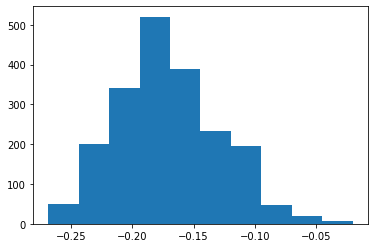

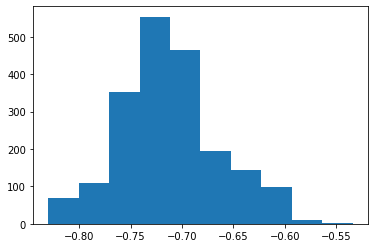

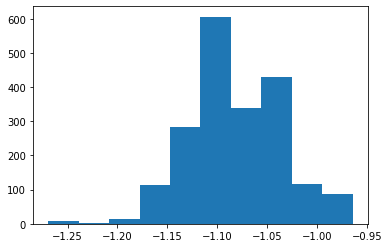

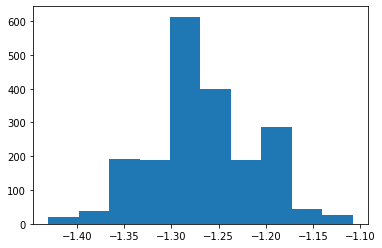

In [20]:
for d in draws:
    plt.hist(d)
    plt.show()